In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [62]:
df_labels = pd.read_excel("labeled_subset_500.xlsx")
#remove all columns but img_name, tweet_id, text_sentiment, image_sentiment by name
df_labels.drop(columns=['created_at', 'language', 'like_count', 'quote_count', 'referenced_tweets', 'retweet_count', 'text', 'recheck_needed'], axis=1, inplace=True)
df_labels.drop(df_labels.columns[4:], axis=1, inplace=True)

In [63]:
df_labels.head()

,img_name,tweet_id,text_sentiment,image_sentiment
0,id_1103707209022783488_2019-03-07.jpg,1103707209022783488,Positive,Positive
1,id_1119275549766180864_2019-04-19.jpg,1119275549766180864,Neutral,Neutral
2,id_1081406708436688896_2019-01-05.jpg,1081406708436688896,Neutral,Positive
3,id_1089285642826088448_2019-01-26.jpg,1089285642826088448,Neutral,Positive
4,id_1156199327586488320_2019-07-30.jpg,1156199327586488320,Positive,Positive


In [65]:
# trim whitespaces from image_sentiment and text_sentiment
df_labels['image_sentiment'] = df_labels['image_sentiment'].str.strip()
df_labels['text_sentiment'] = df_labels['text_sentiment'].str.strip()
df_labels.describe(include='all')


,img_name,tweet_id,text_sentiment,image_sentiment
count,500,5.000000e+02,500,500
unique,500,NaN,3,3
top,id_1103707209022783488_2019-03-07.jpg,NaN,Neutral,Neutral
freq,1,NaN,198,229
mean,NaN,1.150498e+18,NaN,NaN
std,NaN,3.643419e+16,NaN,NaN
min,NaN,1.080492e+18,NaN,NaN
25%,NaN,1.121437e+18,NaN,NaN
50%,NaN,1.152433e+18,NaN,NaN
75%,NaN,1.180680e+18,NaN,NaN


In [89]:
# load gemini predictions
gemini = pd.read_csv("results/responses_subset_small_all_results_updated.csv")
gemini = gemini.drop_duplicates() 

In [90]:
gemini.head()

,image,sentiment,confidence,explanation
0,id_1087717020001542151_2019-01-22.jpg,negative,1.0,'There is no planet B' suggests that Earth is ...
1,id_1105854449824792576_2019-03-13.jpg,prediction failed,0.0,No sentiment detected.
2,id_1088764632901259264_2019-01-25.jpg,negative,0.9,The image shows a group of people who are cons...
3,id_1086040260704985088_2019-01-17.jpg,negative,0.9,The image shows a comparison between the Arcti...
4,id_1106631808890867714_2019-03-15.jpg,positive,0.9,The image shows a group of children holding si...


In [92]:
gemini.describe(include='all')

,image,sentiment,confidence,explanation
count,5000,5000,5000.000000,5000
unique,5000,4,NaN,4628
top,id_1087717020001542151_2019-01-22.jpg,positive,NaN,No sentiment detected.
freq,1,1921,NaN,218
mean,NaN,NaN,0.776852,NaN
std,NaN,NaN,0.210349,NaN
min,NaN,NaN,0.000000,NaN
25%,NaN,NaN,0.700000,NaN
50%,NaN,NaN,0.800000,NaN
75%,NaN,NaN,0.900000,NaN


In [93]:
# compare labels with prediction of gemini 
false_count = 0
true_count = 0
for index, row in df_labels.iterrows():
    if row['img_name'] in gemini['image'].values:
        gemini_row = gemini.loc[gemini['image'] == row['img_name']]
        if row['image_sentiment'].lower() == gemini_row['sentiment'].values[0]:
            true_count += 1
        else:
            false_count += 1

print("True: ", true_count)
print("False: ", false_count)

True:  278
False:  222


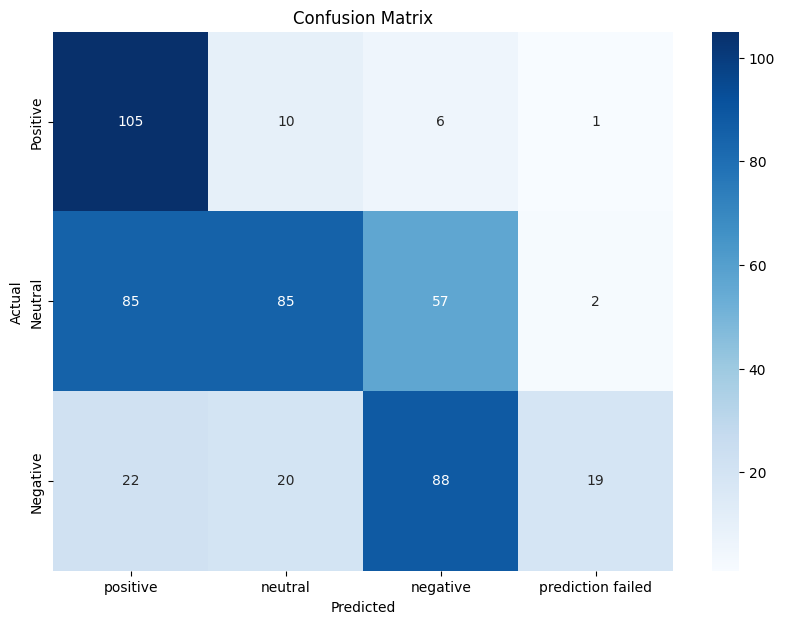

In [97]:
# Merge the dataframes on the 'image' and 'img_name' columns to align them
merged_df = pd.merge(df_labels, gemini, left_on='img_name', right_on='image', how='inner')

# Define the possible categories
truth_categories = ['Positive',  'Neutral', 'Negative']
prediction_categories = ['positive',  'neutral', 'negative', 'prediction failed']

# Initialize the confusion matrix
conf_matrix = np.zeros((len(truth_categories), len(prediction_categories)), dtype=int)

# Fill the confusion matrix
for _, row in merged_df.iterrows():
    truth = row['image_sentiment']
    pred = row['sentiment']
    if pred in prediction_categories:
        i = truth_categories.index(truth)
        j = prediction_categories.index(pred)
        conf_matrix[i, j] += 1

# Convert the confusion matrix to a DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=truth_categories, columns=prediction_categories)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [109]:
# Calculate metrics from confusion matrix
total_samples = conf_matrix.sum()
correct_predictions = np.trace(conf_matrix)
accuracy = correct_predictions / total_samples

precision = {}
recall = {}
f1_score = {}

for i, category in enumerate(truth_categories):
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    fn = conf_matrix[i, :].sum() - tp
    precision[category] = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall[category] = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score[category] = 2 * (precision[category] * recall[category]) / (precision[category] + recall[category]) if (precision[category] + recall[category]) > 0 else 0


# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.56
Precision: {'Positive': 0.49528301886792453, 'Neutral': 0.7391304347826086, 'Negative': 0.5827814569536424}
Recall: {'Positive': 0.860655737704918, 'Neutral': 0.37117903930131, 'Negative': 0.5906040268456376}
F1 Score: {'Positive': 0.62874251497006, 'Neutral': 0.4941860465116278, 'Negative': 0.5866666666666668}


next steps:
- evaluate other models
- look at specific confusions (FP, FN)
- combine with GUI


GUI:
- display of images with same properties in kachelform -> press for more information